**Installing PyTorch**


In [0]:
!pip3 install torchvision

**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Import PyTorch**


In [0]:
import torch
import os
import os.path

import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.folder import default_loader
import torch.nn as nn
from PIL import Image
from torchvision import datasets, models, transforms
import time
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import numpy as np
import torchvision
import warnings

**Define transforms**

In [0]:
data_transforms = {
            'train':
            transforms.Compose([
                transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(),
                transforms.RandomHorizontalFlip(),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
            ]),
            'val':
            transforms.Compose([
                transforms.Resize(size=256),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ]),
        }

**Define device**

In [0]:
device = torch.device(
            "cuda") if torch.cuda.is_available() else torch.device("cpu")

**Path to data**

In [0]:
data_dir = "/content/drive/My Drive/plant_dataset"

**Data Set**

In [0]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                                  data_transforms[x])
                          for x in ['train', 'val']}

**Data Loaders**

In [0]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                           shuffle=True, num_workers=4)
                            for x in ['train', 'val']}

**Parameters for dataset**

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in [
            'train', 'val']}
class_names = image_datasets['train'].classes
epoch_losses = {'train': [], 'val': []}
epoch_accs = {'train': [], 'val': []}

**Show image**

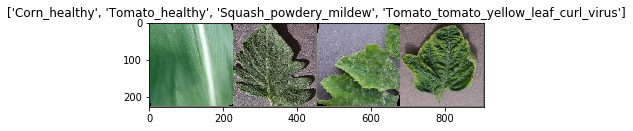

In [9]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
inp = torchvision.utils.make_grid(inputs)

title = [class_names[x] for x in classes]

inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)
if title is not None:
  plt.title(title)
plt.pause(5.1)  # pause a bit so that plots are updated

**Load pre-trained model**

In [10]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet152', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:06<00:00, 38.8MB/s]


**Hyper-parameters**

In [0]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 38)
model = model.to(device)
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = lr_scheduler.StepLR(
            optimizer, step_size=7, gamma=0.1)

**Training**

In [12]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / \
            dataset_sizes[phase]

        epoch_losses[phase].append(epoch_loss)
        epoch_accs[phase].append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            model_path = "/content/drive/My Drive/Plant/model_epochs/model_"+str(epoch)+".pth"
            torch.save(best_model_wts, model_path)

    print()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)


Epoch 0/9
----------
train Loss: 0.9685 Acc: 0.7679
val Loss: 0.1225 Acc: 0.9602

Epoch 1/9
----------
train Loss: 0.2431 Acc: 0.9412
val Loss: 0.0742 Acc: 0.9814

Epoch 2/9
----------
train Loss: 0.1484 Acc: 0.9641
val Loss: 0.0954 Acc: 0.9858

Epoch 3/9
----------
train Loss: 0.1078 Acc: 0.9739
val Loss: 0.0631 Acc: 0.9899

Epoch 4/9
----------
train Loss: 0.0820 Acc: 0.9805
val Loss: 0.0309 Acc: 0.9912

Epoch 5/9
----------
train Loss: 0.0704 Acc: 0.9832
val Loss: 0.0569 Acc: 0.9899

Epoch 6/9
----------
train Loss: 0.0599 Acc: 0.9854
val Loss: 0.0385 Acc: 0.9950

Epoch 7/9
----------
train Loss: 0.0448 Acc: 0.9902
val Loss: 0.0289 Acc: 0.9941

Epoch 8/9
----------
train Loss: 0.0440 Acc: 0.9899
val Loss: 0.0338 Acc: 0.9945

Epoch 9/9
----------
train Loss: 0.0453 Acc: 0.9893
val Loss: 0.0308 Acc: 0.9939

Training complete in 287m 57s
Best val Acc: 0.995026


<All keys matched successfully>

**Saving Model**

In [1]:
torch.save(model, "/content/drive/My Drive/Plant/Models/mymodel.pth")

NameError: ignored

**Saving Plots**

In [0]:
plt.ion()

vars_plots = {"accuracy": [self.epoch_accs, "/content/drive/My Drive/Plant/Plots/Accuracy.png"],
            "loss": [self.epoch_losses, "/content/drive/My Drive/Plant/Plots/Losses.png"]}

for idx in vars_plots:
    plt.figure()
    plot_train = vars_plots[idx]
    plot_dict = plot_train[0]
    plot_file_title = plot_train[1]
    plt.plot(plot_dict['train'], label='Training')
    plt.plot(plot_dict['val'], label='Validation')
    plt.legend(frameon=False)
    plt.savefig(plot_file_title)